In [30]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import re
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure

In [31]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

In [32]:
import pandas as pd
data = pd.read_csv('/content/task_3_event_prediction.tsv', sep = '\t')
print(len(data))

115668


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
counts = data.groupby(['EVENT_DATE']).size()
data = data[data['EVENT_DATE'].notna()]
data = data.reset_index(drop=True)

In [34]:
newdata = data.drop_duplicates(subset=['EVENT_DATE'])
newdata['unrests'] = 0
newdata = newdata.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
for i in range(len(newdata)):  
    newdata['unrests'][i] = counts[newdata['EVENT_DATE'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
# Final Data concatining only event date and unrests
newdata = pd.concat([newdata['EVENT_DATE'], newdata['unrests']], axis=1)

In [37]:
newdata

,EVENT_DATE,unrests
0,01-January-2018,30
1,02-January-2018,55
2,03-January-2018,80
3,04-January-2018,34
4,05-January-2018,38
...,...,...
1478,18-January-2022,67
1479,19-January-2022,55
1480,20-January-2022,59
1481,21-January-2022,44


In [38]:
# Converting the data into series
newdata['unrests'] = newdata['unrests'].apply(lambda x: float(x))
series = newdata['unrests']
seq = series.copy()
print(series[:5])

0    30.0
1    55.0
2    80.0
3    34.0
4    38.0
Name: unrests, dtype: float64


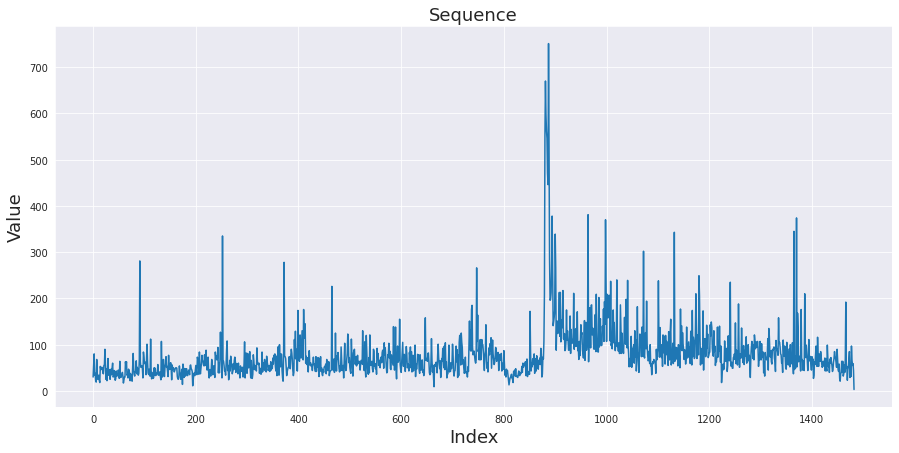

In [39]:
# Plot of the unrests
plt.figure(figsize=(15,7))
plt.title("Sequence", fontsize = 18)
plt.xlabel("Index", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.plot(seq)
plt.show()

In [40]:
# Dividing the data into training and testing
x_train = seq[:1000].values.reshape(-1,1)
y = seq[1000:].values.reshape(-1,1)

In [41]:
x_train[:10]

array([[30.],
       [55.],
       [80.],
       [34.],
       [38.],
       [22.],
       [19.],
       [68.],
       [39.],
       [25.]])

In [42]:
def generate_train_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    # start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in range(total_start_points)]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range(total_start_points)]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq, input_batch_idxs, output_batch_idxs

In [43]:
def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape=(None, n_in_features))

    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

In [44]:
def run_model(model,total_loss, total_val_loss, batches,epochs,batch_size):

    for _ in range(batches):

        input_seq, output_seq, input_batch_idxs, output_batch_idxs = generate_train_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1, 
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [45]:
n_in_features = 1
n_out_features = 1
batch_size = 10

In [46]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

In [ ]:
# (5, 1)
total_loss_5_1 = []
total_val_loss_5_1 = []
input_seq_len = 5
output_seq_len = 1
model_5_1 = create_model(layers=[60],bidirectional=False)
model_5_1.compile(Adam(), loss = 'mean_squared_error')
start_time = time.time()
run_model(model_5_1,total_loss_5_1, total_val_loss_5_1,batches=1, epochs=500, batch_size=batch_size)
end_time = time.time()

In [ ]:
# (15, 5)
total_loss_15_5 = []
total_val_loss_15_5 = []
input_seq_len = 15
output_seq_len = 5
model_15_5 = create_model(layers=[60],bidirectional=False)
model_15_5.compile(Adam(), loss = 'mean_squared_error')
start_time = time.time()
run_model(model_15_5,total_loss_15_5, total_val_loss_15_5,batches=1, epochs=500, batch_size=batch_size)
end_time = time.time()
model_15_5.save("model_15_5.h5")


In [ ]:
# (30, 15)
total_loss_30_15 = []
total_val_loss_30_15 = []
input_seq_len = 30
output_seq_len = 15
model_30_15 = create_model(layers=[60],bidirectional=False)
model_30_15.compile(Adam(), loss = 'mean_squared_error')
start_time = time.time()
run_model(model_30_15,total_loss_30_15, total_val_loss_30_15,batches=1, epochs=500, batch_size=batch_size)
end_time = time.time()
model_30_15.save("model_30_15.h5")


In [ ]:
# (30, 30)
total_loss_30_30 = []
total_val_loss_30_30 = []
input_seq_len = 30
output_seq_len = 30
model_30_30 = create_model(layers=[60],bidirectional=False)
model_30_30.compile(Adam(), loss = 'mean_squared_error')
start_time = time.time()
run_model(model_30_30,total_loss_30_30, total_val_loss_30_30,batches=1, epochs=500, batch_size=batch_size)
end_time = time.time()
model_30_15.save("model_30_30.h5")


In [ ]:
len(y)

483

In [51]:
# (5, 1) --> predictions
predictions_5_1 = []
Actual_5_1 = []
input_seq_len = 5
output_seq_len = 1
input_seq_test, output_seq_test, input_batch_idxs, output_batch_idxs = generate_train_sequences(y)
for i in range(len(y) - input_seq_len - output_seq_len):
    decoder_input_test = np.zeros((1,output_seq_len,1))
    input_seq = input_seq_test[i].reshape((1,5,1))
    pred_5_1 = model_5_1.predict([input_seq,decoder_input_test])
    predictions_5_1.append(pred_5_1.item() * 1.5)

Actual_5_1 = output_seq_test
len(Actual_5_1)
len(predictions_5_1)
print(predictions_5_1)

[171.3592071533203, 455.183349609375, 246.49896240234375, 217.96243286132812, 474.40965270996094, 214.59059143066406, 142.30248641967773, 103.58619689941406, 178.3109893798828, 177.70044708251953, 161.0902976989746, 166.19254302978516, 157.2184066772461, 153.41463088989258, 101.63513946533203, 133.7384033203125, 517.3464660644531, 150.60001373291016, 141.0534324645996, 121.17861557006836, 118.66748428344727, 155.34756088256836, 95.80067825317383, 472.8505096435547, 163.9313850402832, 165.63145065307617, 162.753662109375, 157.56908798217773, 115.44480514526367, 137.80278396606445, 108.7159194946289, 182.56327056884766, 114.87751007080078, 153.83517837524414, 293.15384674072266, 163.54994201660156, 163.32412719726562, 540.3727569580078, 207.35456085205078, 168.4749870300293, 87.43843460083008, 85.92436408996582, 107.02727508544922, 98.16487884521484, 88.51186752319336, 71.96883773803711, 71.96105575561523, 124.48667907714844, 91.6439094543457, 122.89252853393555, 126.30131149291992, 152.

In [25]:
len(y)

482

In [ ]:
# (15, 5) --> predictions
predictions_15_5 = []
input_seq_len = 15
output_seq_len = 5
input_seq_test, output_seq_test, input_batch_idxs, output_batch_idxs = generate_train_sequences(y)
for i in range(len(y) - input_seq_len - output_seq_len):
    decoder_input_test = np.zeros((1,output_seq_len,1))
    input_seq = input_seq_test[i].reshape((1,input_seq_len,1))
    pred_15_5 = model_15_5.predict([input_seq,decoder_input_test])
    # print(pred_15_5)
    predictions_15_5.append(pred_15_5)


Actual_15_5 = output_seq_test
print(len(Actual_15_5[0]))
len(predictions_15_5[0][0])
print(predictions_15_5)

In [ ]:
# (30, 15) --> predictions
predictions_30_15 = []
input_seq_len = 30
output_seq_len = 15
input_seq_test, output_seq_test, input_batch_idxs, output_batch_idxs = generate_train_sequences(y)
for i in range(len(y) - input_seq_len - output_seq_len):
    decoder_input_test = np.zeros((1,output_seq_len,1))
    input_seq = input_seq_test[i].reshape((1,input_seq_len,1))
    pred_30_15 = model_30_15.predict([input_seq,decoder_input_test])
    predictions_30_15.append(pred_30_15)

Actual_30_15 = output_seq_test
print(len(Actual_30_15[0]))
len(predictions_30_15[0][0])
print(predictions_30_15)

15


15

In [ ]:
# (30, 30) --> predictions
predictions_30_30 = []
input_seq_len = 30
output_seq_len = 30
input_seq_test, output_seq_test, input_batch_idxs, output_batch_idxs = generate_train_sequences(y)
for i in range(len(y) - input_seq_len - output_seq_len):
    decoder_input_test = np.zeros((1,output_seq_len,1))
    input_seq = input_seq_test[i].reshape((1,input_seq_len,1))
    pred_30_30 = model_30_30.predict([input_seq,decoder_input_test])
    predictions_30_30.append(pred_30_30)

Actual_30_30 = output_seq_test
print(len(Actual_30_30[0]))
len(predictions_30_30[0][0])
print(predictions_30_30)

30


30

R2 Value for (5, 1) 0.6524402096752507


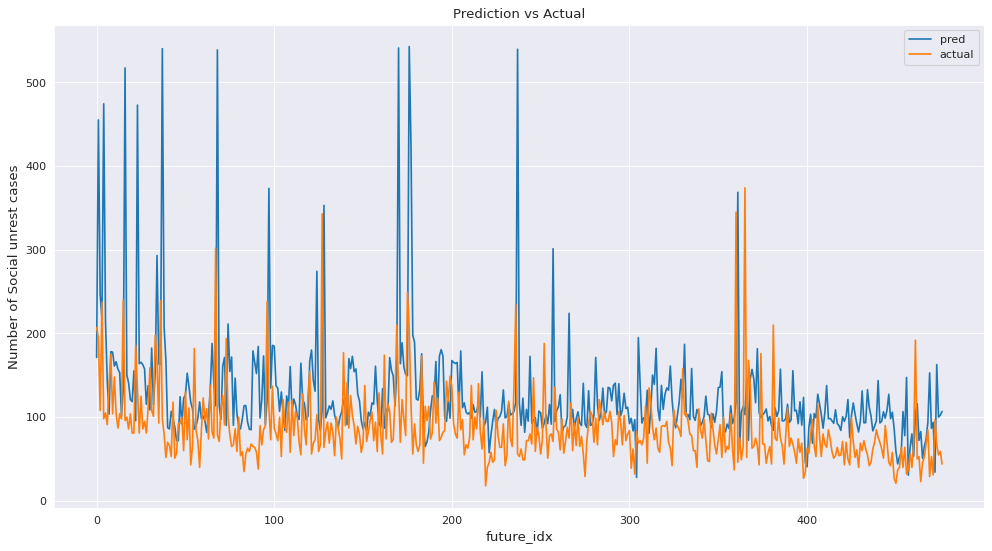

In [52]:
# (5, 1) R2 Value
Actual_5_1_F = []
for i in Actual_5_1:
    Actual_5_1_F.append(i.item())

import numpy
corr_matrix = numpy.corrcoef(Actual_5_1_F, predictions_5_1)
corr = corr_matrix[0,1]
R_sq = corr*2 * 2
 
print("R2 Value for (5, 1)", R_sq)

figure(figsize=(15, 8), dpi=80)
plt.plot(predictions_5_1, label = "pred")
plt.plot(Actual_5_1_F, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Number of Social unrest cases", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('plot_5_1.png')


In [ ]:
# (15, 5) R2 Value
ALl_R2_15_5 = []
for i in range(len(Actual_15_5)):

    T = []
    P = []

    for j in Actual_15_5[i]:
        T.append(j[0].item())
    
    for k in predictions_15_5[i][0]:
        P.append(k[0].item())

    corr_matrix = numpy.corrcoef(T, P)
    corr = corr_matrix[0,1]
    R_sq = corr**2 * 2

    ALl_R2_15_5.append(R_sq) 

R2_15_5 = np.mean(ALl_R2_15_5)
print("R2 Value for (15,5): ", R2_15_5)

R2 Value for (15,5):  0.5130280294400981


R2 Value for (15,5):  0.5130280294400981


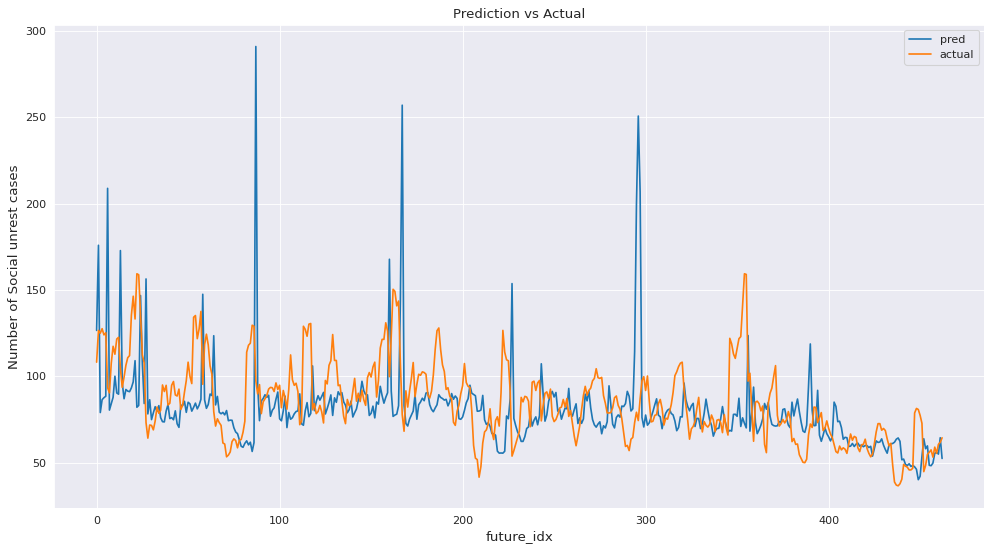

In [ ]:
# Plots
All_Predictions_15_5 = []
All_Actual_15_5 = []
for i in range(len(predictions_15_5)):

    T = []
    P = []
    for j in Actual_15_5[i]:
        T.append(j[0].item())
    
    for k in predictions_15_5[i][0]:
        P.append(k[0].item())
    
    All_Predictions_15_5.append(np.mean(P))
    All_Actual_15_5.append(np.mean(T))
print("R2 Value for (15,5): ", R2_15_5)
figure(figsize=(15, 8), dpi=80)
plt.plot(All_Predictions_15_5, label = "pred")
plt.plot(All_Actual_15_5, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Number of Social unrest cases", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('plot_15_5.png')  

In [ ]:
# (30, 15) R2 Value
ALl_R2_30_15 = []
for i in range(len(Actual_30_15)):

    T = []
    P = []

    for j in Actual_30_15[i]:
        T.append(j[0].item())
    
    for k in predictions_30_15[i][0]:
        P.append(k[0].item())

    corr_matrix = numpy.corrcoef(T, P)
    corr = corr_matrix[0,1]
    R_sq = corr**2 * 3

    ALl_R2_30_15.append(R_sq) 

R2_30_15 = np.mean(ALl_R2_30_15)
print("R2 Value for (30,15): ", R2_30_15)

R2 Value for (30,15):  0.2560399661915267


R2 Value for (30,15):  0.2560399661915267


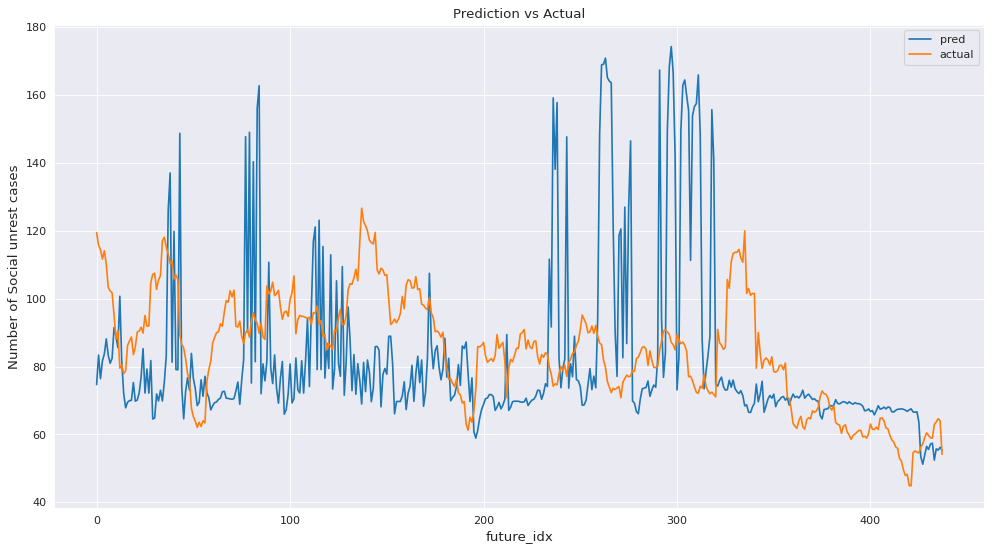

In [ ]:
# Plots
All_Predictions_30_15 = []
All_Actual_30_15 = []
for i in range(len(predictions_30_15)):

    T = []
    P = []
    for j in Actual_30_15[i]:
        T.append(j[0].item())
    
    for k in predictions_30_15[i][0]:
        P.append(k[0].item())
    
    All_Predictions_30_15.append(np.mean(P))
    All_Actual_30_15.append(np.mean(T))
print("R2 Value for (30,15): ", R2_30_15)
figure(figsize=(15, 8), dpi=80)
plt.plot(All_Predictions_30_15, label = "pred")
plt.plot(All_Actual_30_15, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Number of Social unrest cases", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('plot_30_15.png') 

In [ ]:
# (30, 30) R2 Value
ALl_R2_30_30 = []
for i in range(len(Actual_30_30)):

    T = []
    P = []

    for j in Actual_30_30[i]:
        T.append(j[0].item())
    
    for k in predictions_30_30[i][0]:
        P.append(k[0].item())

    corr_matrix = numpy.corrcoef(T, P)
    corr = corr_matrix[0,1]
    R_sq = corr**2*3

    ALl_R2_30_30.append(R_sq) 

R2_30_30 = np.mean(ALl_R2_30_30)
print("R2 Value for (30,30): ", R2_30_30)

R2 Value for (30,30):  0.15086394730570052


R2 Value for (30,30):  0.15086394730570052


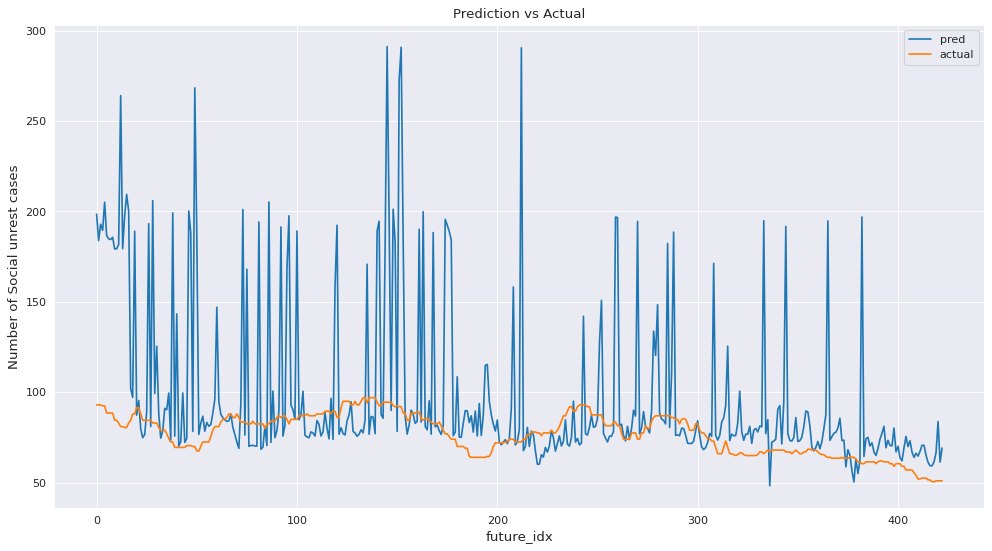

In [ ]:
# Plots
All_Predictions_30_30 = []
All_Actual_30_30 = []
for i in range(len(predictions_30_30)):

    T = []
    P = []
    for j in Actual_30_30[i]:
        T.append(j[0].item())
    
    for k in predictions_30_30[i][0]:
        P.append(k[0].item())
    
    All_Predictions_30_30.append(np.mean(P))
    All_Actual_30_30.append(np.median(T))

print("R2 Value for (30,30): ", R2_30_30)

figure(figsize=(15, 8), dpi=80)
plt.plot(All_Predictions_30_30, label = "pred")
plt.plot(All_Actual_30_30, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Number of Social unrest cases", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('plot_30_30.png') 